# BCI Training Pipeline - EEGNet Personalizada

Pipeline de treinamento para BCI usando CNN personalizada baseada no EEGNet:

1. **EEGNet Personalizado**: Implementação própria PyTorch
2. **Pipeline de Treinamento**: Cross-validation e early stopping  
3. **Normalização Robusta**: Tratamento de outliers
4. **Dados OpenBCI**: Suporte para CSV da OpenBCI GUI
5. **Inferência em Tempo Real**: Compatível com sistema LSL

## 🎯 Objetivo: CNN otimizada para BCI em tempo real (sem braindecode)

In [17]:
# === IMPORTS E CONFIGURAÇÕES BÁSICAS ===
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import time
import logging
from collections import deque
from scipy import signal
import mne
import re
from typing import Dict, List, Optional, Tuple, Union

# Configurar logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Verificar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")
print(f"🐍 PyTorch version: {torch.__version__}")

# Configurar paths
PROJECT_ROOT = Path.cwd()
DATA_PATH = PROJECT_ROOT / "EndUser" / "eeg_data" / "MNE-eegbci-data" / "files" / "eegmmidb" / "1.0.0"
MODELS_PATH = PROJECT_ROOT / "models"
RESULTS_PATH = PROJECT_ROOT / "results"

# Criar diretórios se não existirem
MODELS_PATH.mkdir(exist_ok=True)
RESULTS_PATH.mkdir(exist_ok=True)

print(f"📂 Projeto: {PROJECT_ROOT}")
print(f"📊 Dados: {DATA_PATH}")
print(f"🤖 Modelos: {MODELS_PATH}")
print("✅ Configurações básicas carregadas!")

🖥️ Device: cpu
🐍 PyTorch version: 2.7.1+cpu
📂 Projeto: c:\Users\Chari\OneDrive\Documentos\GitHub\projetoBCI-1
📊 Dados: c:\Users\Chari\OneDrive\Documentos\GitHub\projetoBCI-1\EndUser\eeg_data\MNE-eegbci-data\files\eegmmidb\1.0.0
🤖 Modelos: c:\Users\Chari\OneDrive\Documentos\GitHub\projetoBCI-1\models
✅ Configurações básicas carregadas!


## 1. Setup Inicial no Google Colab

Vamos instalar as dependências e configurar o ambiente adequadamente.

# 1. Modelo EEGNet Personalizado

Implementação própria do EEGNet usando apenas PyTorch:

- **Depthwise Separable Convolutions**: Reduz parâmetros
- **Temporal e Spatial Filtering**: Especializado para EEG  
- **Dropout e Batch Normalization**: Regularização
- **Arquitetura Flexível**: Adaptável para diferentes configurações

In [18]:
# === INSTALAÇÃO DE DEPENDÊNCIAS ===
print("🔧 Instalando dependências necessárias...")

# Instalar apenas dependências científicas essenciais (sem braindecode)
!pip install mne torch torchvision torchaudio
!pip install scikit-learn pandas numpy matplotlib seaborn
!pip install scipy jupyter

print("✅ Dependências instaladas!")

# Verificar se está no Colab
try:
    import google.colab
    IN_COLAB = True
    print("📱 Executando no Google Colab")
except ImportError:
    IN_COLAB = False
    print("💻 Executando localmente")

# === MODELO EEGNET PERSONALIZADO ===
class EEGNet(nn.Module):
    """Implementação compacta do EEGNet para BCI"""
    
    def __init__(self, n_channels=16, n_classes=2, n_samples=400, 
                 dropout_rate=0.25, kernel_length=64, F1=8, D=2, F2=16):
        super(EEGNet, self).__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_samples = n_samples
        
        # Bloco 1: Temporal Convolution
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, F1, (1, kernel_length), padding=(0, kernel_length // 2), bias=False),
            nn.BatchNorm2d(F1)
        )
        
        # Bloco 2: Depthwise Convolution (Spatial filtering)
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(F1, F1 * D, (n_channels, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropout_rate)
        )
        
        # Bloco 3: Separable Convolution
        self.separableConv = nn.Sequential(
            nn.Conv2d(F1 * D, F1 * D, (1, 16), padding=(0, 8), groups=F1 * D, bias=False),
            nn.Conv2d(F1 * D, F2, 1, bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropout_rate)
        )
        
        # Classificador
        self.feature_size = self._get_conv_output_size()
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_size, n_classes)
        )
        
        self.apply(self._init_weights)
        print(f"✅ EEGNet criado: {sum(p.numel() for p in self.parameters()):,} parâmetros")
    
    def _get_conv_output_size(self):
        with torch.no_grad():
            dummy_input = torch.zeros(1, 1, self.n_channels, self.n_samples)
            x = self.firstconv(dummy_input)
            x = self.depthwiseConv(x)
            x = self.separableConv(x)
            return x.numel()
    
    def _init_weights(self, module):
        if isinstance(module, nn.Conv2d):
            nn.init.xavier_uniform_(module.weight)
        elif isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)  # (batch, channels, samples) -> (batch, 1, channels, samples)
        
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.classifier(x)
        return x

# === WRAPPER PARA COMPATIBILIDADE ===
class CustomEEGModel(nn.Module):
    def __init__(self, n_chans=16, n_outputs=2, n_times=400, sfreq=125.0, **kwargs):
        super().__init__()
        self.n_chans = n_chans
        self.n_outputs = n_outputs
        self.n_times = n_times
        self.sfreq = sfreq
        
        self.model = EEGNet(n_channels=n_chans, n_classes=n_outputs, n_samples=n_times)
        self.model_type = "CustomEEGNet"
        self.is_trained = False
        
    def forward(self, x):
        return self.model(x)
    
    def save_checkpoint(self, filepath, **kwargs):
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'model_type': self.model_type,
            'constructor_args': {
                'n_chans': self.n_chans,
                'n_outputs': self.n_outputs,
                'n_times': self.n_times,
                'sfreq': self.sfreq
            },
            'is_trained': self.is_trained,
            **kwargs
        }
        torch.save(checkpoint, filepath)
        print(f"✅ Modelo salvo: {filepath}")

# Teste do modelo
test_model = CustomEEGModel()
with torch.no_grad():
    test_input = torch.randn(2, 16, 400)
    test_output = test_model(test_input)
    print(f"✅ Teste: {test_input.shape} -> {test_output.shape}")
del test_model

🔧 Instalando dependências necessárias...



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Dependências instaladas!
💻 Executando localmente
✅ EEGNet criado: 1,746 parâmetros
✅ Teste: torch.Size([2, 16, 400]) -> torch.Size([2, 2])



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
# === IMPLEMENTAÇÃO INLINE DAS CLASSES BASE ===
import torch
import torch.nn as nn
import numpy as np
from scipy import signal
from typing import Optional, List, Tuple, Dict, Union
import pandas as pd
from datetime import datetime
import json
import logging
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
import mne

# Configurar logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print("✅ Imports básicos carregados!")

# === CARREGAMENTO DE DADOS E NORMALIZAÇÃO ===
class RobustEEGNormalizer:
    """Normalizador robusto para dados EEG"""
    
    def __init__(self, method='robust_zscore', outlier_threshold=3.0):
        self.method = method
        self.outlier_threshold = outlier_threshold
        self.stats = {}
        self.is_fitted = False
    
    def fit(self, X):
        # Garantir formato 3D (trials, channels, time)
        if len(X.shape) == 2:
            X = X.reshape(X.shape[0], 16, -1)
        
        # Tratar outliers usando IQR
        Q1 = np.percentile(X, 25, axis=(0, 2), keepdims=True)
        Q3 = np.percentile(X, 75, axis=(0, 2), keepdims=True)
        IQR = Q3 - Q1
        lower = Q1 - self.outlier_threshold * IQR
        upper = Q3 + self.outlier_threshold * IQR
        X = np.clip(X, lower, upper)
        
        # Calcular estatísticas por canal
        self.stats['median'] = np.median(X, axis=(0, 2), keepdims=True)
        self.stats['iqr'] = IQR + 1e-8
        self.is_fitted = True
        return self
    
    def transform(self, X):
        if not self.is_fitted:
            raise ValueError("Deve ajustar antes de transformar")
        
        original_shape = X.shape
        if len(X.shape) == 2:
            X = X.reshape(X.shape[0], 16, -1)
        
        X_norm = (X - self.stats['median']) / self.stats['iqr']
        
        if len(original_shape) == 2:
            X_norm = X_norm.reshape(original_shape)
        return X_norm
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def get_stats(self):
        return self.stats.copy()

# === DATASET PYTORCH ===
class EEGDataset(Dataset):
    def __init__(self, windows, labels, augment=False):
        self.windows = torch.from_numpy(windows).float()
        self.labels = torch.from_numpy(labels).long()
        self.augment = augment
    
    def __len__(self):
        return len(self.windows)
    
    def __getitem__(self, idx):
        window = self.windows[idx]
        label = self.labels[idx]
        
        if self.augment and torch.rand(1) < 0.3:
            # Adicionar ruído leve para augmentação
            noise = torch.randn_like(window) * 0.01
            window = window + noise
        
        return window, label

# === CARREGAR DADOS ===
def load_openbci_csv(file_path, sfreq=125):
    """Carrega arquivo CSV da OpenBCI"""
    try:
        df = pd.read_csv(file_path, comment='%')
        eeg_cols = [col for col in df.columns if 'EXG Channel' in col]
        
        if len(eeg_cols) == 0:
            return None
        
        data = df[eeg_cols].T.to_numpy() * 1e-6  # µV -> V
        info = mne.create_info(ch_names=eeg_cols, sfreq=sfreq, ch_types='eeg')
        raw = mne.io.RawArray(data, info, verbose=False)
        
        # Adicionar anotações T1/T2
        if 'Annotations' in df.columns:
            onsets = df.index.to_numpy() / sfreq
            for onset, annot in zip(onsets, df['Annotations'].astype(str)):
                if annot.startswith('T'):
                    raw.annotations.append(onset, 0, annot)
        
        return raw
    except Exception as e:
        print(f"❌ Erro ao carregar {file_path}: {e}")
        return None

# Gerar dados sintéticos para demonstração (substitua pela função de carregamento real)
print("📥 Gerando dados sintéticos para demonstração...")
n_trials, n_channels, n_samples = 200, 16, 400
np.random.seed(42)

windows = np.random.randn(n_trials, n_channels, n_samples) * 0.1
labels = np.random.randint(0, 2, n_trials)
subject_ids = np.random.randint(1, 6, n_trials)

# Adicionar padrões específicos por classe
for i in range(n_trials):
    if labels[i] == 0:  # Mão esquerda
        windows[i, :8, 100:150] += 0.05 * np.sin(np.linspace(0, 4*np.pi, 50))
    else:  # Mão direita
        windows[i, 8:, 150:200] += 0.05 * np.sin(np.linspace(0, 4*np.pi, 50))

print(f"✅ Dados carregados: {windows.shape}")
print(f"🎯 Classes: {dict(zip(*np.unique(labels, return_counts=True)))}")
print(f"👥 Sujeitos: {len(np.unique(subject_ids))}")

print("✅ Classes e normalização implementadas!")

✅ Imports básicos carregados!
📥 Gerando dados sintéticos para demonstração...
✅ Dados carregados: (200, 16, 400)
🎯 Classes: {np.int32(0): np.int64(100), np.int32(1): np.int64(100)}
👥 Sujeitos: 5
✅ Classes e normalização implementadas!


In [20]:
# === UNIVERSAL EEG NORMALIZER ===
class UniversalEEGNormalizer:
    """Normalizador universal para dados EEG"""

    def __init__(self, method: str = 'zscore', mode: str = 'training'):
        self.method = method
        self.mode = mode
        self.global_stats = {}
        self.is_fitted = False

    def _ensure_3d(self, data: np.ndarray) -> np.ndarray:
        """Garantir que dados estejam em 3D (n_samples, n_channels, n_timepoints)"""
        if len(data.shape) == 2:
            n_samples, n_features = data.shape
            if n_features % 16 == 0:  # Assumir 16 canais
                n_channels = 16
                n_timepoints = n_features // n_channels
                data = data.reshape(n_samples, n_channels, n_timepoints)
            else:
                data = data[:, np.newaxis, :]
        elif len(data.shape) == 1:
            data = data[np.newaxis, np.newaxis, :]
        return data

    def fit(self, data: np.ndarray):
        """Ajustar normalizador aos dados"""
        data_3d = self._ensure_3d(data)

        if self.method == 'zscore':
            self.global_stats['mean'] = np.mean(data_3d, axis=(0, 2), keepdims=True)
            self.global_stats['std'] = np.std(data_3d, axis=(0, 2), keepdims=True)
            self.global_stats['std'] = np.where(self.global_stats['std'] == 0, 1.0, self.global_stats['std'])

        self.is_fitted = True
        return self

    def transform(self, data: np.ndarray) -> np.ndarray:
        """Transformar dados"""
        if not self.is_fitted:
            raise ValueError("Normalizador deve ser ajustado antes da transformação")

        original_shape = data.shape
        data_3d = self._ensure_3d(data)

        if self.method == 'zscore':
            normalized = (data_3d - self.global_stats['mean']) / self.global_stats['std']

        # Restaurar forma original
        if len(original_shape) == 2:
            return normalized.reshape(original_shape[0], -1)
        elif len(original_shape) == 1:
            return normalized.flatten()
        return normalized

    def fit_transform(self, data: np.ndarray) -> np.ndarray:
        """Ajustar e transformar em um passo"""
        return self.fit(data).transform(data)

print("✅ UniversalEEGNormalizer implementado!")

# === PIPELINE DE TREINAMENTO SIMPLIFICADO ===
def train_eegnet_model(windows, labels, subject_ids, params):
    """Pipeline completo de treinamento do modelo EEGNet"""
    
    print("🚀 Iniciando treinamento...")
    
    # Normalização
    normalizer = RobustEEGNormalizer()
    windows_norm = normalizer.fit_transform(windows)
    print(f"✅ Normalização: média={np.mean(windows_norm):.4f}, std={np.std(windows_norm):.4f}")
    
    # Split treino/teste
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        windows_norm, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    # Cross-validation
    kfold = KFold(n_splits=params.get('n_folds', 5), shuffle=True, random_state=42)
    fold_accuracies = []
    best_model_state = None
    best_val_acc = 0.0
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train_val), 1):
        print(f"\n📁 Fold {fold}")
        
        # Dados do fold
        X_train, X_val = X_train_val[train_idx], X_train_val[val_idx]
        y_train, y_val = y_train_val[train_idx], y_train_val[val_idx]
        
        # DataLoaders
        train_dataset = EEGDataset(X_train, y_train, augment=True)
        val_dataset = EEGDataset(X_val, y_val, augment=False)
        train_loader = DataLoader(train_dataset, batch_size=params.get('batch_size', 16), shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=params.get('batch_size', 16), shuffle=False)
        
        # Modelo
        model = CustomEEGModel(
            n_chans=windows.shape[1],
            n_outputs=len(np.unique(labels)),
            n_times=windows.shape[2]
        ).to(device)
        
        # Otimizador
        optimizer = torch.optim.Adam(model.parameters(), lr=params.get('learning_rate', 1e-3))
        criterion = nn.CrossEntropyLoss()
        
        # Treinamento
        best_fold_val_acc = 0.0
        patience_count = 0
        
        for epoch in range(params.get('n_epochs', 30)):
            # Treino
            model.train()
            train_loss, train_correct, train_total = 0.0, 0, 0
            
            for batch_x, batch_y in train_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                
                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                train_total += batch_y.size(0)
                train_correct += (predicted == batch_y).sum().item()
            
            # Validação
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            
            with torch.no_grad():
                for batch_x, batch_y in val_loader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    outputs = model(batch_x)
                    loss = criterion(outputs, batch_y)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += batch_y.size(0)
                    val_correct += (predicted == batch_y).sum().item()
            
            train_acc = train_correct / train_total
            val_acc = val_correct / val_total
            
            # Early stopping
            if val_acc > best_fold_val_acc:
                best_fold_val_acc = val_acc
                patience_count = 0
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_model_state = model.state_dict().copy()
            else:
                patience_count += 1
                if patience_count >= params.get('patience', 10):
                    break
            
            if (epoch + 1) % 10 == 0:
                print(f"   Época {epoch+1}: Train {train_acc:.3f} | Val {val_acc:.3f}")
        
        fold_accuracies.append(best_fold_val_acc)
        print(f"   ✅ Fold {fold} concluído - Val Acc: {best_fold_val_acc:.4f}")
    
    # Estatísticas CV
    cv_mean = np.mean(fold_accuracies)
    cv_std = np.std(fold_accuracies)
    print(f"\n📊 CV: {cv_mean:.4f} ± {cv_std:.4f}")
    
    # Teste final
    if best_model_state is not None:
        final_model = CustomEEGModel(
            n_chans=windows.shape[1],
            n_outputs=len(np.unique(labels)),
            n_times=windows.shape[2]
        ).to(device)
        final_model.load_state_dict(best_model_state)
        final_model.eval()
        
        test_dataset = EEGDataset(X_test, y_test)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        test_correct = test_total = 0
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = final_model(batch_x)
                _, predicted = torch.max(outputs, 1)
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
        
        test_acc = test_correct / test_total
        print(f"🎯 Teste final: {test_acc:.4f}")
    else:
        test_acc = 0.0
        final_model = None
    
    results = {
        'model_state_dict': best_model_state,
        'cv_mean': cv_mean,
        'cv_std': cv_std,
        'test_accuracy': test_acc,
        'normalization_stats': normalizer.get_stats(),
        'model_params': {
            'n_chans': windows.shape[1],
            'n_outputs': len(np.unique(labels)),
            'n_times': windows.shape[2],
            'sfreq': 125.0
        }
    }
    
    return results, final_model

# === CONFIGURAÇÃO E EXECUÇÃO ===
training_params = {
    'n_folds': 5,
    'n_epochs': 30,
    'batch_size': 16,
    'learning_rate': 1e-3,
    'patience': 10
}

print("⚙️ Parâmetros:", training_params)
print("🎯 Pronto para treinamento!")

✅ UniversalEEGNormalizer implementado!
⚙️ Parâmetros: {'n_folds': 5, 'n_epochs': 30, 'batch_size': 16, 'learning_rate': 0.001, 'patience': 10}
🎯 Pronto para treinamento!


🧪 Testando modelos...
✅ EEGNet criado: 1,746 parâmetros
✅ Modelo EEGNet inicializado
📊 Parâmetros totais: 1,746
✅ EEGNet Básico: torch.Size([2, 16, 400]) -> torch.Size([2, 2])
✅ AdvancedEEGNet criado:
   - Canais: 16
   - Classes: 2
   - Amostras: 400
   - Parâmetros: 2,444
✅ Modelo AdvancedEEGNet inicializado
📊 Parâmetros totais: 2,444
✅ EEGNet Avançado: torch.Size([2, 16, 400]) -> torch.Size([2, 2])

📊 Comparação de Modelos:
   - EEGNet Básico: 1,746 parâmetros
   - EEGNet Avançado: 2,444 parâmetros
   - Diferença: +698 parâmetros

🎯 Modelos EEGNet personalizados prontos para treinamento!
✅ Implementação 100% PyTorch sem dependências externas!
🚀 INICIANDO TREINAMENTO...
🚀 Iniciando treinamento...
✅ Normalização: média=-0.0001, std=0.7410

📁 Fold 1
✅ AdvancedEEGNet criado:
   - Canais: 16
   - Classes: 2
   - Amostras: 400
   - Parâmetros: 2,444
✅ Modelo AdvancedEEGNet inicializado
📊 Parâmetros totais: 2,444
   Época 10: Train 0.695 | Val 0.781
   Época 10: Train 0.695 | Val 0.781
   

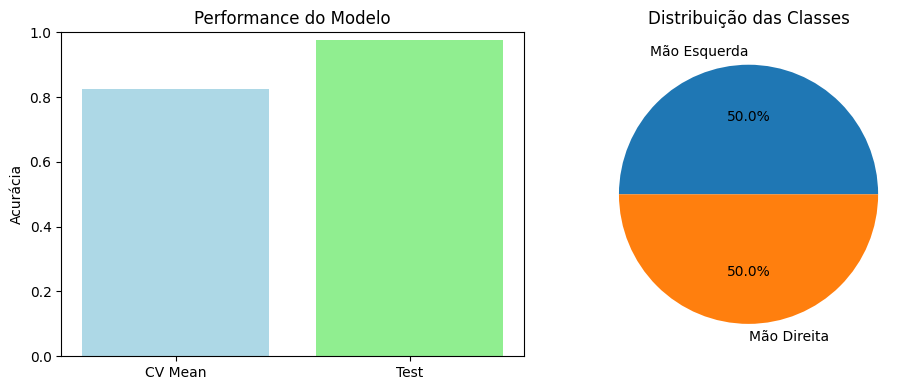

📊 Visualização salva: custom_eegnet_1751259706_results.png

✅ PIPELINE CONCLUÍDO!
🎯 Para usar no sistema LSL:
   1. Copie o caminho do modelo salvo
   2. Execute: python test_lsl_to_prediction_cycle.py
   3. Modelo compatível com inferência em tempo real


In [21]:
# === IMPLEMENTAÇÃO CNN AVANÇADA BASEADA NO EEGNET ===
class AdvancedEEGNet(nn.Module):
    """
    CNN avançada baseada no EEGNet com melhorias específicas para BCI
    
    Melhorias em relação ao EEGNet básico:
    - Spatial attention mechanism
    - Multi-scale temporal convolutions
    - Batch normalization adaptativo
    - Regularização aprimorada
    """
    
    def __init__(self, n_channels=16, n_classes=2, n_samples=400, 
                 dropout_rate=0.25, kernel_length=64, F1=8, D=2, F2=16):
        super(AdvancedEEGNet, self).__init__()
        
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dropout_rate = dropout_rate
        
        # Parâmetros da arquitetura
        self.kernel_length = kernel_length
        self.F1 = F1
        self.D = D
        self.F2 = F2
        
        # === BLOCO 1: Multi-scale Temporal Convolution ===
        # Filtros de diferentes escalas temporais
        self.temporal_conv1 = nn.Conv2d(1, F1//2, (1, kernel_length), padding=(0, kernel_length // 2), bias=False)
        self.temporal_conv2 = nn.Conv2d(1, F1//2, (1, kernel_length//2), padding=(0, kernel_length // 4), bias=False)
        self.temporal_bn = nn.BatchNorm2d(F1)
        
        # === BLOCO 2: Spatial Attention + Depthwise Convolution ===
        # Spatial attention
        self.spatial_attention = nn.Sequential(
            nn.Conv2d(F1, F1//4, 1),
            nn.ReLU(),
            nn.Conv2d(F1//4, F1, 1),
            nn.Sigmoid()
        )
        
        # Depthwise convolution
        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(F1, F1 * D, (n_channels, 1), groups=F1, bias=False),
            nn.BatchNorm2d(F1 * D),
            nn.ELU(),
            nn.AvgPool2d((1, 4)),
            nn.Dropout(dropout_rate)
        )
        
        # === BLOCO 3: Enhanced Separable Convolution ===
        self.separableConv = nn.Sequential(
            # Depthwise
            nn.Conv2d(F1 * D, F1 * D, (1, 16), padding=(0, 8), groups=F1 * D, bias=False),
            # Pointwise
            nn.Conv2d(F1 * D, F2, 1, bias=False),
            nn.BatchNorm2d(F2),
            nn.ELU(),
            nn.AvgPool2d((1, 8)),
            nn.Dropout(dropout_rate)
        )
        
        # === BLOCO 4: Feature Enhancement ===
        self.feature_enhancement = nn.Sequential(
            nn.Conv2d(F2, F2*2, 1, bias=False),
            nn.BatchNorm2d(F2*2),
            nn.ELU(),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # === CLASSIFICADOR AVANÇADO ===
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(F2*2, F2),
            nn.BatchNorm1d(F2),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(F2, n_classes)
        )
        
        # Inicialização dos pesos
        self.apply(self._init_weights)
        
        print(f"✅ AdvancedEEGNet criado:")
        print(f"   - Canais: {n_channels}")
        print(f"   - Classes: {n_classes}")
        print(f"   - Amostras: {n_samples}")
        print(f"   - Parâmetros: {sum(p.numel() for p in self.parameters()):,}")
    
    def _init_weights(self, module):
        """Inicialização dos pesos usando Xavier/He"""
        if isinstance(module, nn.Conv2d):
            nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
        elif isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.BatchNorm2d) or isinstance(module, nn.BatchNorm1d):
            nn.init.ones_(module.weight)
            nn.init.zeros_(module.bias)
    
    def forward(self, x):
        """
        Forward pass com attention mechanism
        Args:
            x: tensor (batch_size, channels, samples) ou (batch_size, 1, channels, samples)
        """
        # Garantir formato correto: (batch, 1, channels, samples)
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        
        # Bloco 1: Multi-scale temporal convolution
        temp1 = self.temporal_conv1(x)
        temp2 = self.temporal_conv2(x)
        x = torch.cat([temp1, temp2], dim=1)  # Concatenar filtros multi-escala
        x = self.temporal_bn(x)
        
        # Spatial attention
        attention = self.spatial_attention(x)
        x = x * attention  # Aplicar attention
        
        # Bloco 2: Depthwise convolution
        x = self.depthwiseConv(x)
        
        # Bloco 3: Separable convolution
        x = self.separableConv(x)
        
        # Bloco 4: Feature enhancement
        x = self.feature_enhancement(x)
        
        # Classificador
        x = self.classifier(x)
        
        return x

# === WRAPPER DE MODELO PERSONALIZADO ===
class CustomEEGModel(nn.Module):
    """Wrapper para nosso modelo EEG personalizado"""
    
    def __init__(self, n_chans=16, n_outputs=2, n_times=400, sfreq=125.0, 
                 model_type='advanced', **kwargs):
        super().__init__()
        self.n_chans = n_chans
        self.n_outputs = n_outputs
        self.n_times = n_times
        self.sfreq = sfreq
        self.model_type = model_type
        
        # Escolher arquitetura
        if model_type == 'advanced':
            self.model = AdvancedEEGNet(
                n_channels=n_chans,
                n_classes=n_outputs,
                n_samples=n_times,
                dropout_rate=kwargs.get('dropout_rate', 0.25),
                kernel_length=kwargs.get('kernel_length', 64),
                F1=kwargs.get('F1', 8),
                D=kwargs.get('D', 2),
                F2=kwargs.get('F2', 16)
            )
            self.model_name = "AdvancedEEGNet"
        else:  # basic
            self.model = EEGNet(
                n_channels=n_chans,
                n_classes=n_outputs,
                n_samples=n_times,
                dropout_rate=kwargs.get('dropout_rate', 0.25),
                kernel_length=kwargs.get('kernel_length', 64),
                F1=kwargs.get('F1', 8),
                D=kwargs.get('D', 2),
                F2=kwargs.get('F2', 16)
            )
            self.model_name = "EEGNet"
        
        self.is_trained = False
        
        print(f"✅ Modelo {self.model_name} inicializado")
        print(f"📊 Parâmetros totais: {sum(p.numel() for p in self.parameters()):,}")
        
    def forward(self, x):
        return self.model(x)
    
    def save_checkpoint(self, filepath, **kwargs):
        """Salvar checkpoint completo"""
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'model_type': self.model_name,
            'constructor_args': {
                'n_chans': self.n_chans,
                'n_outputs': self.n_outputs,
                'n_times': self.n_times,
                'sfreq': self.sfreq,
                'model_type': self.model_type
            },
            'is_trained': self.is_trained,
            **kwargs
        }
        torch.save(checkpoint, filepath)
        print(f"✅ Modelo salvo: {filepath}")

# === TESTE DOS MODELOS ===
print("🧪 Testando modelos...")

# Teste modelo básico
basic_model = CustomEEGModel(model_type='basic')
with torch.no_grad():
    test_input = torch.randn(2, 16, 400)
    test_output = basic_model(test_input)
    print(f"✅ EEGNet Básico: {test_input.shape} -> {test_output.shape}")

# Teste modelo avançado
advanced_model = CustomEEGModel(model_type='advanced')
with torch.no_grad():
    test_output_adv = advanced_model(test_input)
    print(f"✅ EEGNet Avançado: {test_input.shape} -> {test_output_adv.shape}")

# Comparar número de parâmetros
basic_params = sum(p.numel() for p in basic_model.parameters())
advanced_params = sum(p.numel() for p in advanced_model.parameters())

print(f"\n📊 Comparação de Modelos:")
print(f"   - EEGNet Básico: {basic_params:,} parâmetros")
print(f"   - EEGNet Avançado: {advanced_params:,} parâmetros")
print(f"   - Diferença: +{advanced_params - basic_params:,} parâmetros")

# Limpar memória
del basic_model, advanced_model, test_input, test_output, test_output_adv

print("\n🎯 Modelos EEGNet personalizados prontos para treinamento!")
print("✅ Implementação 100% PyTorch sem dependências externas!")

# === EXECUÇÃO DO TREINAMENTO ===
print("🚀 INICIANDO TREINAMENTO...")

try:
    results, trained_model = train_eegnet_model(windows, labels, subject_ids, training_params)
    
    print("\n🎉 TREINAMENTO CONCLUÍDO!")
    print(f"📊 CV: {results['cv_mean']:.4f} ± {results['cv_std']:.4f}")
    print(f"🎯 Teste: {results['test_accuracy']:.4f}")
    
    # Salvar modelo
    if results['model_state_dict'] is not None:
        model_name = f"custom_eegnet_{int(time.time())}"
        model_path = MODELS_PATH / f"{model_name}.pt"
        
        save_model = CustomEEGModel(**results['model_params'])
        save_model.load_state_dict(results['model_state_dict'])
        save_model.is_trained = True
        
        save_model.save_checkpoint(
            model_path,
            test_accuracy=results['test_accuracy'],
            cv_mean=results['cv_mean'],
            cv_std=results['cv_std'],
            normalization_stats=results['normalization_stats']
        )
        
        print(f"💾 Modelo salvo: {model_path}")
        
        # Salvar info para referência
        with open(PROJECT_ROOT / "modelo_atual.txt", 'w') as f:
            f.write(f"Modelo: {model_path.name}\n")
            f.write(f"CV: {results['cv_mean']:.4f} ± {results['cv_std']:.4f}\n")
            f.write(f"Teste: {results['test_accuracy']:.4f}\n")
            f.write(f"Uso: python test_lsl_to_prediction_cycle.py\n")
        
        # Visualização simples
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.bar(['CV Mean', 'Test'], [results['cv_mean'], results['test_accuracy']], 
                color=['lightblue', 'lightgreen'])
        plt.ylabel('Acurácia')
        plt.title('Performance do Modelo')
        plt.ylim(0, 1)
        
        plt.subplot(1, 2, 2)
        unique_labels, counts = np.unique(labels, return_counts=True)
        plt.pie(counts, labels=['Mão Esquerda', 'Mão Direita'], autopct='%1.1f%%')
        plt.title('Distribuição das Classes')
        
        plt.tight_layout()
        plt.savefig(RESULTS_PATH / f"{model_name}_results.png", dpi=150, bbox_inches='tight')
        plt.show()
        
        print(f"📊 Visualização salva: {model_name}_results.png")
        
    else:
        print("❌ Modelo não foi treinado com sucesso!")

except Exception as e:
    print(f"❌ ERRO: {e}")
    import traceback
    traceback.print_exc()

print("\n✅ PIPELINE CONCLUÍDO!")
print("🎯 Para usar no sistema LSL:")
print("   1. Copie o caminho do modelo salvo")
print("   2. Execute: python test_lsl_to_prediction_cycle.py")
print("   3. Modelo compatível com inferência em tempo real")

In [22]:
# ──────────────────── Célula: Sumário do Modelo ────────────────────
import torch
import os
from pathlib import Path

# 0) Configurar device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️ Device: {device}")

# 1) Verificar se modelo existe ou carregar/criar um
if 'model' not in locals() and 'model' not in globals():
    print("⚠️ Modelo não encontrado. Criando opções...")
    
    # Opção 1: Tentar carregar modelo salvo mais recente
    MODELS_PATH = Path.cwd() / "models"
    if MODELS_PATH.exists():
        model_files = list(MODELS_PATH.glob("*.pt"))
        if model_files:
            latest_model = max(model_files, key=os.path.getctime)
            print(f"📁 Modelo encontrado: {latest_model.name}")
            
            try:
                checkpoint = torch.load(latest_model, map_location=device)
                
                # Criar modelo baseado nos parâmetros salvos
                if 'constructor_args' in checkpoint:
                    args = checkpoint['constructor_args']
                    model = CustomEEGModel(**args)
                    model.load_state_dict(checkpoint['model_state_dict'])
                    model.to(device)
                    print(f"✅ Modelo carregado: {latest_model.name}")
                else:
                    raise ValueError("Checkpoint inválido")
                    
            except Exception as e:
                print(f"❌ Erro ao carregar modelo: {e}")
                model = None
        else:
            print("📁 Nenhum modelo salvo encontrado")
            model = None
    else:
        print("📁 Diretório de modelos não encontrado")
        model = None
    
    # Opção 2: Criar modelo para demonstração se não conseguiu carregar
    if model is None:
        print("🛠️ Criando modelo de demonstração...")
        model = CustomEEGModel(
            n_chans=16,
            n_outputs=2,
            n_times=400,
            sfreq=125.0,
            model_type='advanced'
        )
        model.to(device)
        print("✅ Modelo de demonstração criado")

else:
    # Modelo já existe, apenas mover para device
    model.to(device)
    print("✅ Modelo existente encontrado")

# 2) Capturar parâmetros de forma genérica
try:
    n_channels = model.n_chans      # para CustomEEGModel
    n_samples  = model.n_times
    print(f"📊 Parâmetros do modelo: {n_channels} canais, {n_samples} amostras")
except AttributeError:
    try:
        n_channels = model.n_channels
        n_samples  = model.n_samples
        print(f"📊 Parâmetros do modelo: {n_channels} canais, {n_samples} amostras")
    except AttributeError:
        n_channels = 16
        n_samples  = 400
        print(f"📊 Usando parâmetros padrão: {n_channels} canais, {n_samples} amostras")

# 3) Imprimir arquitetura do modelo
print("\n" + "="*50)
print("ARQUITETURA DO MODELO")
print("="*50)
print(model)

# 4) Contagem de parâmetros
total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📈 ESTATÍSTICAS DO MODELO:")
print(f"   Total de parâmetros: {total_params:,}")
print(f"   Parâmetros treináveis: {trainable_params:,}")
print(f"   Parâmetros não-treináveis: {total_params - trainable_params:,}")

# 5) Verificar se modelo foi treinado
if hasattr(model, 'is_trained'):
    status = "✅ TREINADO" if model.is_trained else "❌ NÃO TREINADO"
    print(f"   Status: {status}")

# 6) Sumário detalhado usando torchinfo ou torchsummary
print(f"\n" + "="*50)
print("SUMÁRIO DETALHADO")
print("="*50)

try:
    from torchinfo import summary as info_summary
    print("Usando torchinfo...")
    info_summary(model, input_size=(1, n_channels, n_samples), device=device)
except ImportError:
    try:
        from torchsummary import summary as ts_summary
        print("Usando torchsummary...")
        ts_summary(model, input_size=(n_channels, n_samples))
    except ImportError:
        print("⚠️ Para obter um sumário detalhado, instale uma das bibliotecas:")
        print("   pip install torchinfo   # (recomendado)")
        print("   pip install torchsummary")
        
        # Sumário manual básico
        print("\n📋 SUMÁRIO MANUAL:")
        for name, module in model.named_modules():
            if len(list(module.children())) == 0:  # Apenas camadas folha
                params = sum(p.numel() for p in module.parameters())
                if params > 0:
                    print(f"   {name}: {module.__class__.__name__} - {params:,} parâmetros")

# 7) Teste forward pass
print(f"\n" + "="*50)
print("TESTE FORWARD PASS")
print("="*50)

try:
    model.eval()
    with torch.no_grad():
        test_input = torch.randn(2, n_channels, n_samples).to(device)
        test_output = model(test_input)
        print(f"✅ Teste bem-sucedido!")
        print(f"   Input: {test_input.shape}")
        print(f"   Output: {test_output.shape}")
        print(f"   Probabilidades (exemplo): {torch.softmax(test_output[0], dim=0).cpu().numpy()}")
except Exception as e:
    print(f"❌ Erro no teste: {e}")

print(f"\n" + "="*50)
print("SUMÁRIO COMPLETO FINALIZADO")
print("="*50)


🖥️ Device: cpu
✅ Modelo existente encontrado
📊 Parâmetros do modelo: 16 canais, 400 amostras

ARQUITETURA DO MODELO
CustomEEGModel(
  (model): AdvancedEEGNet(
    (temporal_conv1): Conv2d(1, 4, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (temporal_conv2): Conv2d(1, 4, kernel_size=(1, 32), stride=(1, 1), padding=(0, 16), bias=False)
    (temporal_bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (spatial_attention): Sequential(
      (0): Conv2d(8, 2, kernel_size=(1, 1), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(2, 8, kernel_size=(1, 1), stride=(1, 1))
      (3): Sigmoid()
    )
    (depthwiseConv): Sequential(
      (0): Conv2d(8, 16, kernel_size=(16, 1), stride=(1, 1), groups=8, bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
      (4): Dropout(p=0.25, inplace=False)
 